**IFSP - Campus Campinas** <br>
**Pós-graduação em Ciência de Dados** <br>

**TCC - Avaliação de Projetos de Lei usando técnicas de NLP/ML**

#### Vetorização e Text Clustering - v 1.1 
- Vetorização de PLOs da Câmara Municipal de Campinas de 2019
- Text Clustering

Ref.:  NLP - XGBoost, BERT, GloVe, RNNs, Vectorizers <br>
https://www.kaggle.com/code/namansood/nlp-xgboost-bert-glove-rnns-vectorizers

Orientadora: Bianca Maria Pedrosa - IFSP Campinas<br>
Aluno: Swift Motoo Yaguchi - CP301665X

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install --upgrade pip

In [3]:
#!pip install plotly

In [4]:
#!pip install xgboost

In [5]:
#!pip install --upgrade --user tensorflow
#!pip install --upgrade keras

In [6]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras

from keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, BatchNormalization, Dropout, Dense

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.layers.embeddings import Embedding
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

In [7]:
# Defining the global variables for the color schemes we will incorporate
pblue = "#496595"
pb2 = "#85a1c1"
pb3 = "#3f4d63"
pg = "#c6ccd8"
pb = "#202022"
pbg = "#f4f0ea"

pgreen = px.colors.qualitative.Plotly[2]

In [28]:
#df = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv')
df = pd.read_csv('PLO_2019_v5.csv', sep=';')
df.head()

,Vereador,Partido,Aprovado,Ementa,Texto
0,Ailton da Farmácia,PSD,sim,DECLARA ÓRGÃO DE UTILIDADE PÚBLICA MUNICIPAL A...,Art. I Q Fica declarada órgão de utilidade púb...
1,Ailton da Farmácia,PSD,sim,DENOMINA PRAÇA ZILDA MELLO SMILGYS UMA PRAÇA P...,Art. I P Fica denominada Praça Zilda Mello Smi...
2,Ailton da Farmácia,PSD,sim,DENOMINA RUA JOSÉ LATARO UMA VIA PÚBLICA DO MU...,Art. 10 Fica denominada Rua José Lataro a Rua ...
3,Ailton da Farmácia,PSD,sim,DENOMINA PRAÇA ROBERTO ANGELO CASTELLO UMA ÁRE...,Art. 1 0 Fica denominada Praça Roberto Angelo ...
4,Ailton da Farmácia,PSD,não,DISPÕE SOBRE A GRATUIDADE POR ATÉ DUAS HORAS D...,Art. 1 0 Institui a gratuidade por até duas ho...


In [29]:
colunas_desejadas = ['Aprovado', 'Texto']
df = df[colunas_desejadas].copy()

In [30]:
df.head()

,Aprovado,Texto
0,sim,Art. I Q Fica declarada órgão de utilidade púb...
1,sim,Art. I P Fica denominada Praça Zilda Mello Smi...
2,sim,Art. 10 Fica denominada Rua José Lataro a Rua ...
3,sim,Art. 1 0 Fica denominada Praça Roberto Angelo ...
4,não,Art. 1 0 Institui a gratuidade por até duas ho...


In [31]:
df.dtypes

Aprovado    object
Texto       object
dtype: object

In [32]:
df.isnull().sum()

Aprovado    0
Texto       0
dtype: int64

In [33]:
df.rename(columns={"Aprovado":"label", "Texto":"text"}, inplace=True)
df.head()

,label,text
0,sim,Art. I Q Fica declarada órgão de utilidade púb...
1,sim,Art. I P Fica denominada Praça Zilda Mello Smi...
2,sim,Art. 10 Fica denominada Rua José Lataro a Rua ...
3,sim,Art. 1 0 Fica denominada Praça Roberto Angelo ...
4,não,Art. 1 0 Institui a gratuidade por até duas ho...


In [34]:
# Finding maximum length of text message

np.max(df['text'].apply(lambda x: len(x.split())).values)

5507

<h2>Exploratory data analysis</h2>

In [35]:
# Checking balance of dataset
grouped_df = df.groupby('label').count().values.flatten()
grouped_df

array([189, 181], dtype=int64)

The 'text' property is a string and must be specified as:

      - A string
      - A number that will be converted to a string
      - A tuple, list, or one-dimensional numpy array 
      
The 'x' and 'y' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [36]:
fig = go.Figure()

fig.add_trace(go.Bar(
        x=['sim'],
        y=[grouped_df[0]],
        name='Aprovado',
        text=[grouped_df[0]],
        textposition='auto',
        marker_color=pblue
)
             )
fig.add_trace(go.Bar(
        x=['não'],
        y=[grouped_df[1]],
        name='Reprovado',
        text=[grouped_df[1]],
        textposition='auto',
        marker_color=pg
))

fig.update_layout(
    title='Class distribution in the dataset')

fig.show()

In [37]:
# Creating series with length as index
# Sorting the series by index i.e. length
len_df_sim = df[df['label']=='sim'].text.apply(lambda x: len(x.split())).value_counts().sort_index()
len_df_não = df[df['label']=='não'].text.apply(lambda x: len(x.split())).value_counts().sort_index()
print("Textos 'sim' :")
print(len_df_sim)

print("\nTextos 'não' :")
print(len_df_não)

Textos 'sim' :
text
19      1
22      1
24      1
27      3
28      3
       ..
1496    1
1574    1
3300    1
4012    1
5507    1
Name: count, Length: 98, dtype: int64

Textos 'não' :
text
14      1
15      4
25      2
27      6
28      7
       ..
930     1
992     1
1126    1
1553    1
1625    1
Name: count, Length: 126, dtype: int64


In [38]:
# X-axis consists of the length of the msgs
# Y-axis consists of the frequency of those lengths

fig = go.Figure()
fig.add_trace(go.Scatter(
x=len_df_sim.index,
y=len_df_sim.values,
name='Aprovado',
fill='tozeroy',
marker_color=pblue))

fig.add_trace(go.Scatter(
x=len_df_não.index,
y=len_df_não.values,
name='Reprovado',
fill='tozeroy',
marker_color=pg
))

fig.update_layout(
    title='Frequency of Text lengths')
fig.update_xaxes(range=[0, 80])
fig.show()

Podemos observar que o tamanho do texto é geralmente menor para os PLOs reprovados

<h2>Data preprocessing</h2>

In [39]:
def cleaning(text):
    text = str(text).lower() # Lowercase
    text = str(text).strip() # Remove leading/trailing whitespace
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [40]:
df['text']

0      Art. I Q Fica declarada órgão de utilidade púb...
1      Art. I P Fica denominada Praça Zilda Mello Smi...
2      Art. 10 Fica denominada Rua José Lataro a Rua ...
3      Art. 1 0 Fica denominada Praça Roberto Angelo ...
4      Art. 1 0 Institui a gratuidade por até duas ho...
                             ...                        
365    Art. I P Fica instituída a Semana dos Esportes...
366    Art. 1 0 Fica denominado Praça Antonio Alexand...
367    Art. 10 A critério da Secretaria Municipal de ...
368    Art. I Q Fica alterado o inciso IV do S 2 2, f...
369    Art. 1 0 Fica denominado Praça Subtenente Giov...
Name: text, Length: 370, dtype: object

In [41]:
df['text'] = df['text'].apply(cleaning)
df['text']

0      art i q fica declarada órgão de utilidade públ...
1      art i p fica denominada praça zilda mello smil...
2      art  fica denominada rua josé lataro a rua  do...
3      art   fica denominada praça roberto angelo cas...
4      art   institui a gratuidade por até duas horas...
                             ...                        
365    art i p fica instituída a semana dos esportes ...
366    art   fica denominado praça antonio alexandre ...
367    art  a critério da secretaria municipal de fin...
368    art i q fica alterado o inciso iv do s   fica ...
369    art   fica denominado praça subtenente giovani...
Name: text, Length: 370, dtype: object

In [42]:
# Removing stop words
stop_words = stopwords.words('portuguese')
more = ['art', 'i', 'a', 'do', 'p', 's', 'q', 'iv', 'fica', 'dos', 'v', 'io', 'dev', 'dest', 'lei','%', 'município', 'municipal', 'campinas', 'dispõe', 'sobre', 'outra', 'provident', 'dá', 'outro', 'outras', 'outros', 'públic']
stop_words = stop_words + more


def sw_rem(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['text'] = df['text'].apply(sw_rem)
df['text']

0      declarada órgão utilidade pública adra — núcle...
1      denominada praça zilda mello smilgys praça  qu...
2       denominada rua josé lataro rua  eamento parqu...
3        denominada praça roberto angelo castello ár ...
4        institui gratuidade duas horas estacionament...
                             ...                        
365    instituída semana esportes eletrônicos play ha...
366      denominado praça antonio alexandre sobrinho ...
367     critério secretaria finanças poderá concedida...
368    alterado inciso   suprimido inciso   ficam acr...
369      denominado praça subtenente giovani josé tiv...
Name: text, Length: 370, dtype: object

<h2>Stemming and lemmatization</h2>

Documents and other forms of text use different forms of the same words, such as play, playing, played. There are families of derivationally related words that have similar meanings. Our main task with stemming and lemmatization is to reduce all these derived words into the parent/family word, therefore reducing the total vocabulary while retaining information.

* **Stemming** - Omits the ends of words to achieve the goal correctly, this works **most of the times** and can also remove the derivational suffix

* **Lemmatization** - Working with a vocabulary and morphological analysis of wrods, removing inflectional endings only and returning the base and dictionary form of a word.

As we do not require much emphasis on words, we will focus more on stemming than lemmatization,.

<h3>Stemming algorithms</h3>

We have multiple algorithms to achieve our stemming goals, some of them are as follows:

* PorterStemmer - Fast and efficient. Strips off the end (suffix) to produce the stems. It does not follow linguistics but rather a set of 05 rules for diferent cases. 

* SnowballStemmer - Generate a set of rules for any language. These are useful for non-english stemming tasks.

* LancasterStemmer - Iterative algorithm, uses about 120 rules, it tries to find an applicable rule by the last character of each word. The last character may be omitted or replaced.

In [43]:
stems = nltk.SnowballStemmer('portuguese')

def stemming(text):
    # text = ' '.join(stems.stem(word) for word in text.split())
    return text

In [44]:
df['text'] = df['text'].apply(stemming)
df.head()

,label,text
0,sim,declarada órgão utilidade pública adra — núcle...
1,sim,denominada praça zilda mello smilgys praça qu...
2,sim,denominada rua josé lataro rua eamento parqu...
3,sim,denominada praça roberto angelo castello ár ...
4,não,institui gratuidade duas horas estacionament...


In [45]:
# Creating a pipeline

def pipeline(text):
    text = cleaning(text)
    text = ' ' .join(word for word in text.split(' ') if word not in stop_words)
    #text = ' '.join(stems.stem(word) for word in text.split(' '))
    return text

In [46]:
df['text'] = df['text'].apply(pipeline)
df.head()

,label,text
0,sim,declarada órgão utilidade pública adra — núcle...
1,sim,denominada praça zilda mello smilgys praça qu...
2,sim,denominada rua josé lataro rua eamento parque...
3,sim,denominada praça roberto angelo castello ár pe...
4,não,institui gratuidade duas horas estacionamento ...


In [47]:
# Encoding the categorical target variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['label'])

df['label_num'] = le.transform(df['label'])
df.head()

,label,text,label_num
0,sim,declarada órgão utilidade pública adra — núcle...,1
1,sim,denominada praça zilda mello smilgys praça qu...,1
2,sim,denominada rua josé lataro rua eamento parque...,1
3,sim,denominada praça roberto angelo castello ár pe...,1
4,não,institui gratuidade duas horas estacionamento ...,0


<h2>Visualizing tokens</h2>

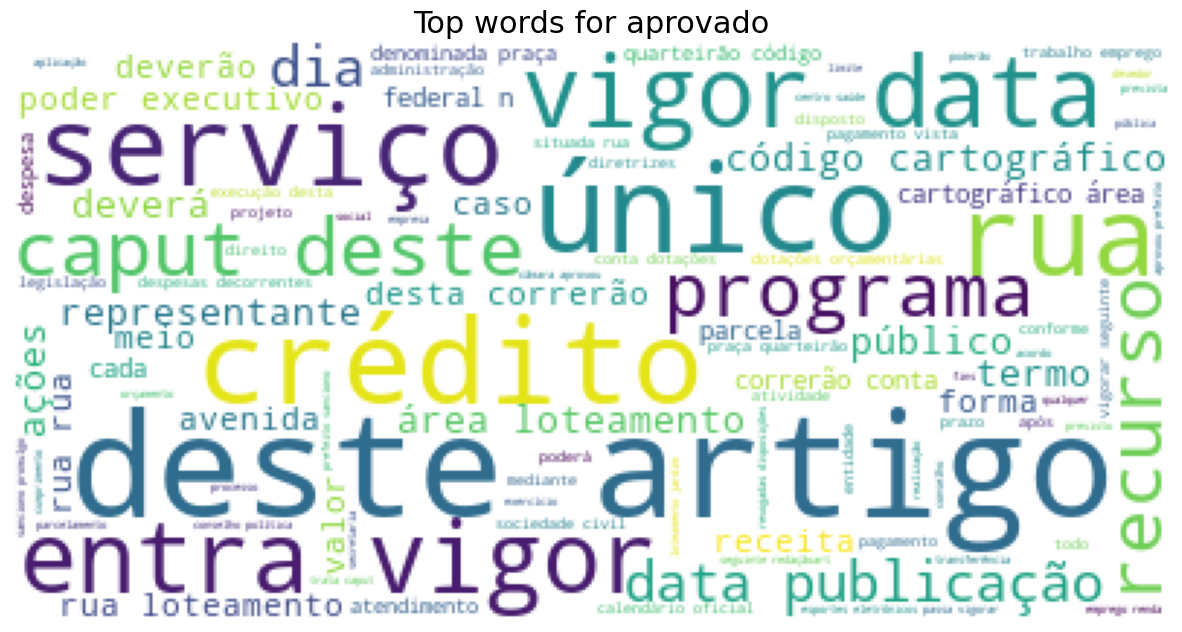

In [48]:
# Extracting the twitter word cloud mask
#twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

#wc = WordCloud(background_color='white', max_words=200, mask=twitter_mask)
wc = WordCloud(background_color='white')

wc.generate(' '.join(text for text in df[df['label']=='sim'].text))
plt.figure(figsize=(15, 10))
plt.title('Top words for aprovado', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()

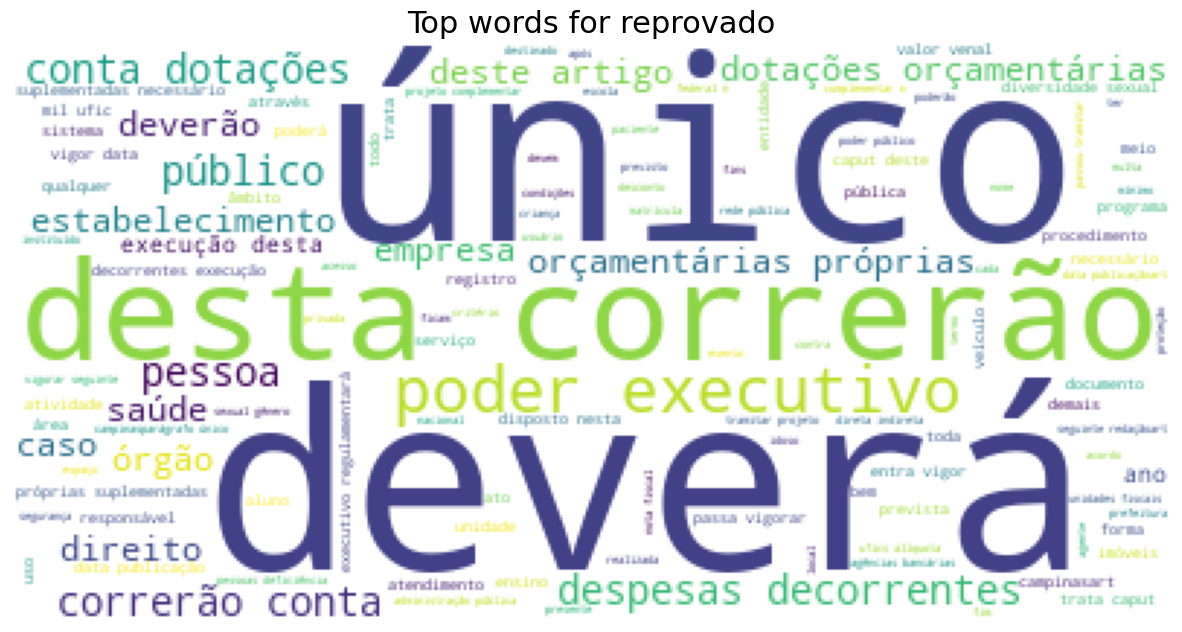

In [49]:
# Extracting the twitter word cloud mask
#wc = WordCloud(background_color='white', max_words=200, mask=twitter_mask)
wc = WordCloud(background_color='white')

wc.generate(' '.join(text for text in df[df['label']=='não'].text))
plt.figure(figsize=(15, 10))
plt.title('Top words for reprovado', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()

<h2>Vectorization</h2>

We currently have each text record in string format. We need to convert each of those records into a vector that our models can work with. We will first do this using the bag-of-words model.

We will use two major approaches here

* **CountVectorizer** - Working on frequency of each word in the given string.

* **Term frequency-inverse document frqeuency TFIDF** - Works on frequency divided by the appearance of the given word in the total documents.

In [50]:
x = df['text']
y = df['label_num']

len(x), len(y)

(370, 370)

In [51]:
#from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(x, y)
#print(len(x_train), len(y_train))
#@print(len(x_test), len(y_test))

In [52]:
# First working with count vectorizer

from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
count = CountVectorizer()
count.fit(x)

#x_train_num = count.transform(x_train)
#x_test_num = count.transform(x_test)
x_num = count.transform(x)

The CountVectorizer model can be tuned in a variety of ways:

* Stop words - Extremely common words can be omitted by the model by setting this parameter to the language corresponding to the text.

* ngram_range - It pairs up words together as features. If we consider bigrams and we have a sentence "I am happy", we will have two features - ["I am", "am happy"]. We can define a range of ngrams, so if we have the same sentence with a range from 1 to 2, our features will be:  `["I", "am", "happy", "I am", "am happy"]`. This increase is features helps to fine tune the model.

* min_df, max_df - Minimum and maximum frequencies of words of n-grams that can be used as features. If either of the conditions are not met, the feature will be omitted.

* max_features - Choose the most frequent words and drop everything else.

In [53]:
# Example of a tuned model
count_tuned = CountVectorizer(stop_words='portuguese', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [54]:
# Working with TF-IDF now
from sklearn.feature_extraction.text import TfidfTransformer
# We are using transformer here
# If we use vectorizer, we can directly use the text
tfidf = TfidfTransformer()

tfidf.fit(x_num)
x_tfidf = tfidf.transform(x_num)

x_tfidf

<370x7800 sparse matrix of type '<class 'numpy.float64'>'
	with 25839 stored elements in Compressed Sparse Row format>

In [55]:
print(x_tfidf)

  (0, 7778)	0.1621708453836018
  (0, 7453)	0.20985432589360933
  (0, 6901)	0.18549708885121377
  (0, 6892)	0.15958792713024225
  (0, 6624)	0.2603716925501185
  (0, 6074)	0.13764094851681122
  (0, 5900)	0.30532868742961916
  (0, 5583)	0.1504332521370138
  (0, 5072)	0.18767807529226863
  (0, 5070)	0.24386297965728576
  (0, 4935)	0.1708517941960651
  (0, 4380)	0.30532868742961916
  (0, 4335)	0.2003282326533197
  (0, 4080)	0.23731137990226636
  (0, 2084)	0.21349036804567884
  (0, 2011)	0.30532868742961916
  (0, 1315)	0.2854349002778591
  (0, 1003)	0.2003282326533197
  (0, 176)	0.30532868742961916
  (1, 7758)	0.1149536011979843
  (1, 7745)	0.2535076874173735
  (1, 7720)	0.2535076874173735
  (1, 6899)	0.2535076874173735
  (1, 6892)	0.1325023425970927
  (1, 6848)	0.17725635263676107
  :	:
  (368, 68)	0.09243470090330322
  (368, 9)	0.10568134647109717
  (369, 7758)	0.2358002289303578
  (369, 7618)	0.2217220751436622
  (369, 7207)	0.260005646215764
  (369, 7010)	0.260005646215764
  (369, 6894)	

In [56]:
print(x_tfidf.shape)

(370, 7800)


## Text Clustering

<b>We'll cluster converted data in this section, using Kmeans clustering.
    Mainly <u>three parts</u> in the section, each are:</b>
    
* 1. <mark>Kmeans clustering</mark> (elbow, silhoutte scoring);
* 2. <mark>PCA</mark> to reduce dimension of vector;
* 3. Kmeans clustering <mark>after PCA</mark>

In [57]:
# For Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer


In [58]:
#def get_all_str(tweet):
def get_all_str(Texto):
    sentence = ''
#    for words in tweet:
    for words in Texto:
        sentence += words
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
#    lst = stopwords.words('english')
    lst = stopwords.words('portuguese')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=50,
               colormap= colormap,
               max_font_size=140,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

### Clustering before PCA

<b style='color:blue'>k-means clustering</b> is a method of vector quantization, originally from signal processing, <br>that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean <br>(cluster centers or cluster centroid), serving as a prototype of the cluster. - source: wikipedia

#### Distortion Score Elbow before PCA

<b style='color:blue'>Elbow method</b> is to select the <mark>optimal number of clusters</mark> by fitting the model with a range of values for k.

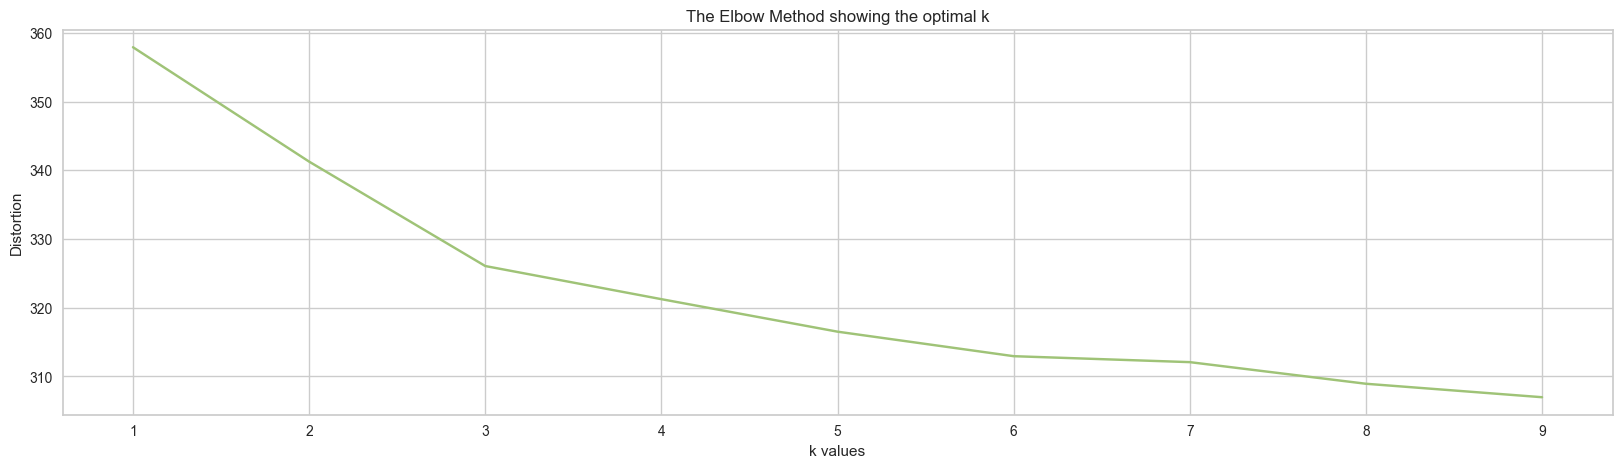

In [59]:
distortions = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k,random_state=7)
    kmean.fit(x_tfidf)
    distortions.append(kmean.inertia_)
    
plt.figure(figsize=(20,5))
plt.plot(K, distortions, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<b>The line shows some "elbow" at K=3, but let´s look into silhouette score of each k values next</b>.

#### Silhouette score of each k values before PCA

<b style='color:blue'>The silhouette value</b> is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).<br> The silhouette ranges from −1 to +1, <br>where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 

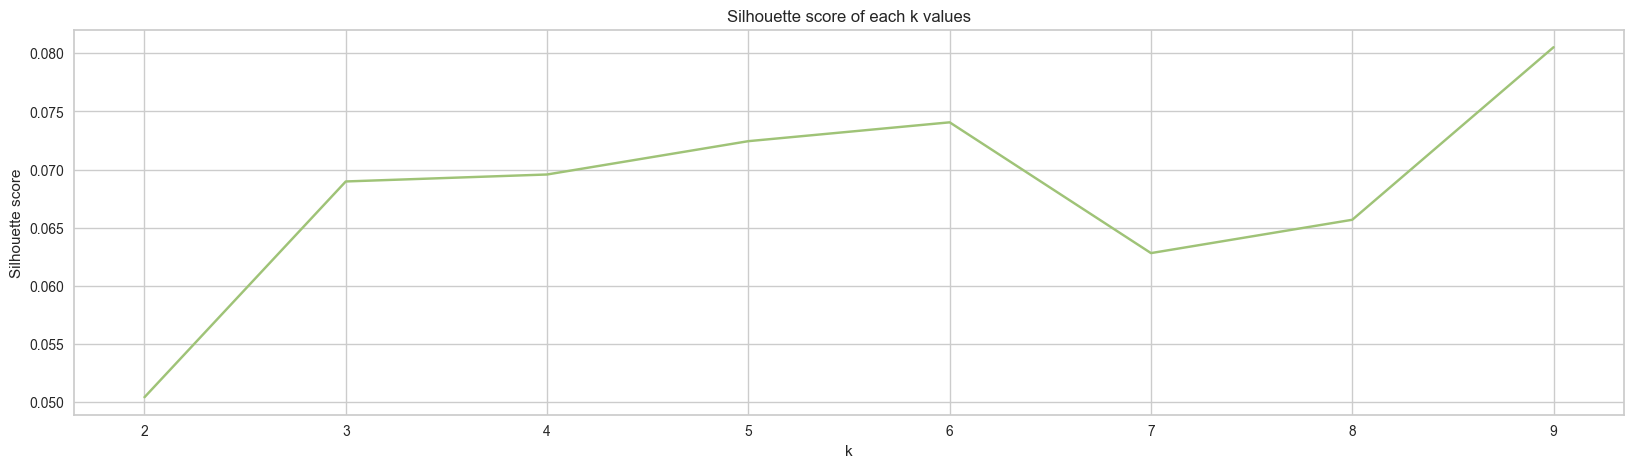

In [60]:
K = range(2,10)
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x_tfidf)
    preds = kmeanModel.predict(x_tfidf)
    silhouette.append(silhouette_score(x_tfidf, preds))
    
plt.figure(figsize=(20,5))
plt.plot(K, silhouette, '-',color='g')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score of each k values')
plt.show()

<b>Since high dimension on data, silhouette scores are too low. Thus we'll use PCA method to <mark>reduce dimension</mark> into 2 in the next section.</b>

#### Clustering after PCA

<b style='color:blue'>Principal component analysis (PCA)</b> is the process of computing the principal components and using them to perform a change of basis on the data,<br> sometimes using only the first few principal components and ignoring the rest.

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PCA = pca.fit(x_tfidf.toarray())
X_pca = pca.transform(x_tfidf.toarray())

### Distortion Score Elbow after PCA

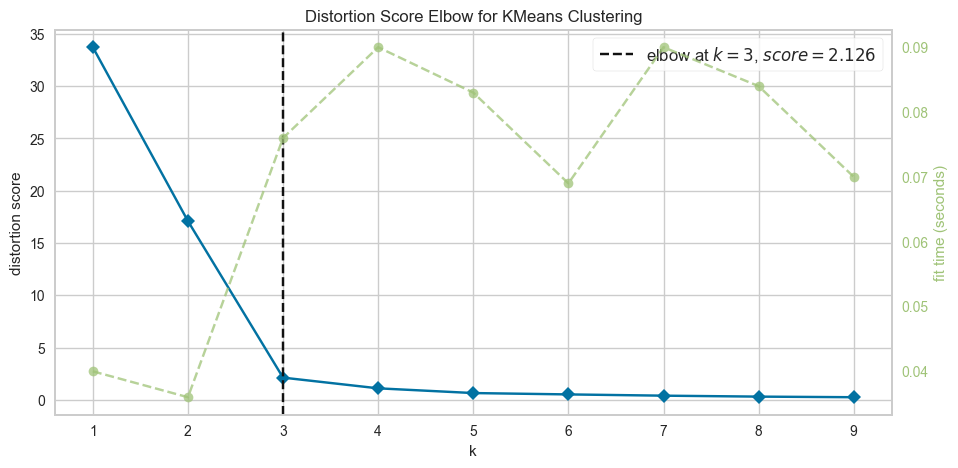

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10),size=(1080, 500))

visualizer.fit(X_pca)        
visualizer.show() 

<b> Now we found that optimal <mark>k vlaue is 3</mark>, let's look into silhouette score below</b>:

#### Silhouette score of each k values after PCA

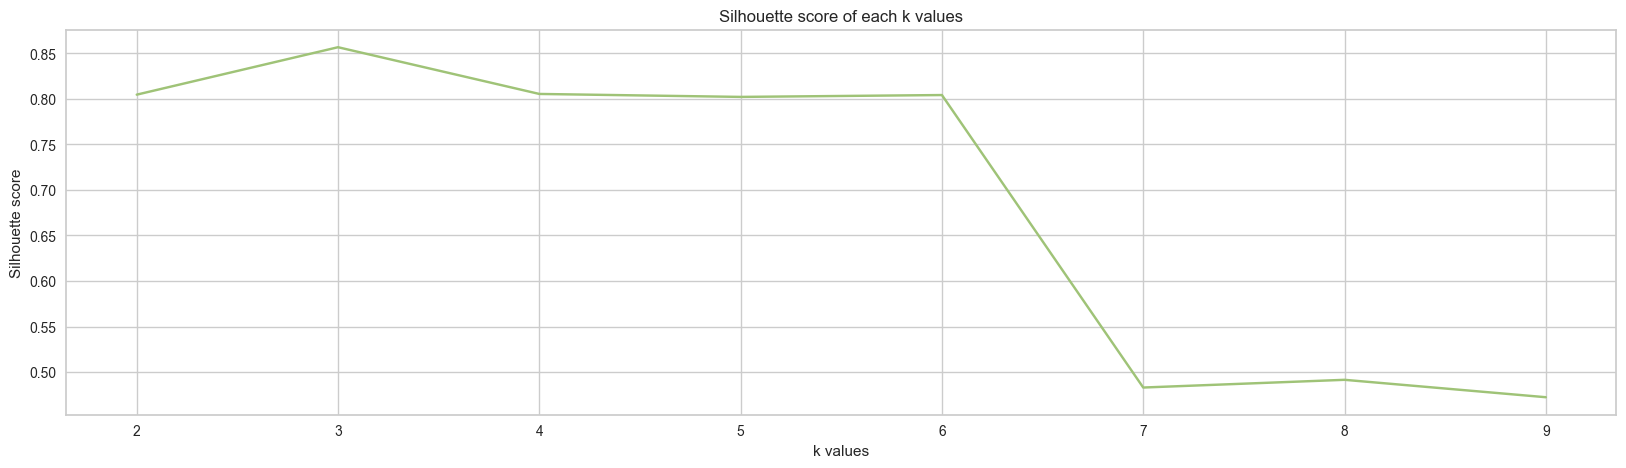

In [63]:
silhouette = []
K = range(2,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_pca)
    preds = kmeanModel.predict(X_pca)
    silhouette.append(silhouette_score(X_pca, preds))
    
plt.figure(figsize=(20,5))
plt.plot(K, silhouette, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Silhouette score')
plt.title('Silhouette score of each k values')
plt.show()

<b>We can notice that silhouette score has improved, and the best score is at k = 3, <mark>about 0.85</mark></b>.

#### Scatter plot on clusters

In [64]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(X_pca)
pred_labels = kmeanModel.labels_;
pred_centers = kmeanModel.cluster_centers_
df_centers = pd.DataFrame(pred_centers, columns=['x', 'y'])
df_centers.head(1)

,x,y
0,0.03508,-0.101148


In [65]:
dfcl = pd.DataFrame(columns=['x','y','label'])
dfcl['x'] = X_pca[:,0]
dfcl['y'] = X_pca[:,1]
dfcl['label'] = kmeanModel.labels_
dfcl.head(1)

,x,y,label
0,0.011163,-0.075761,0


<b><mark>Scatter plot</mark> as below:</b>.

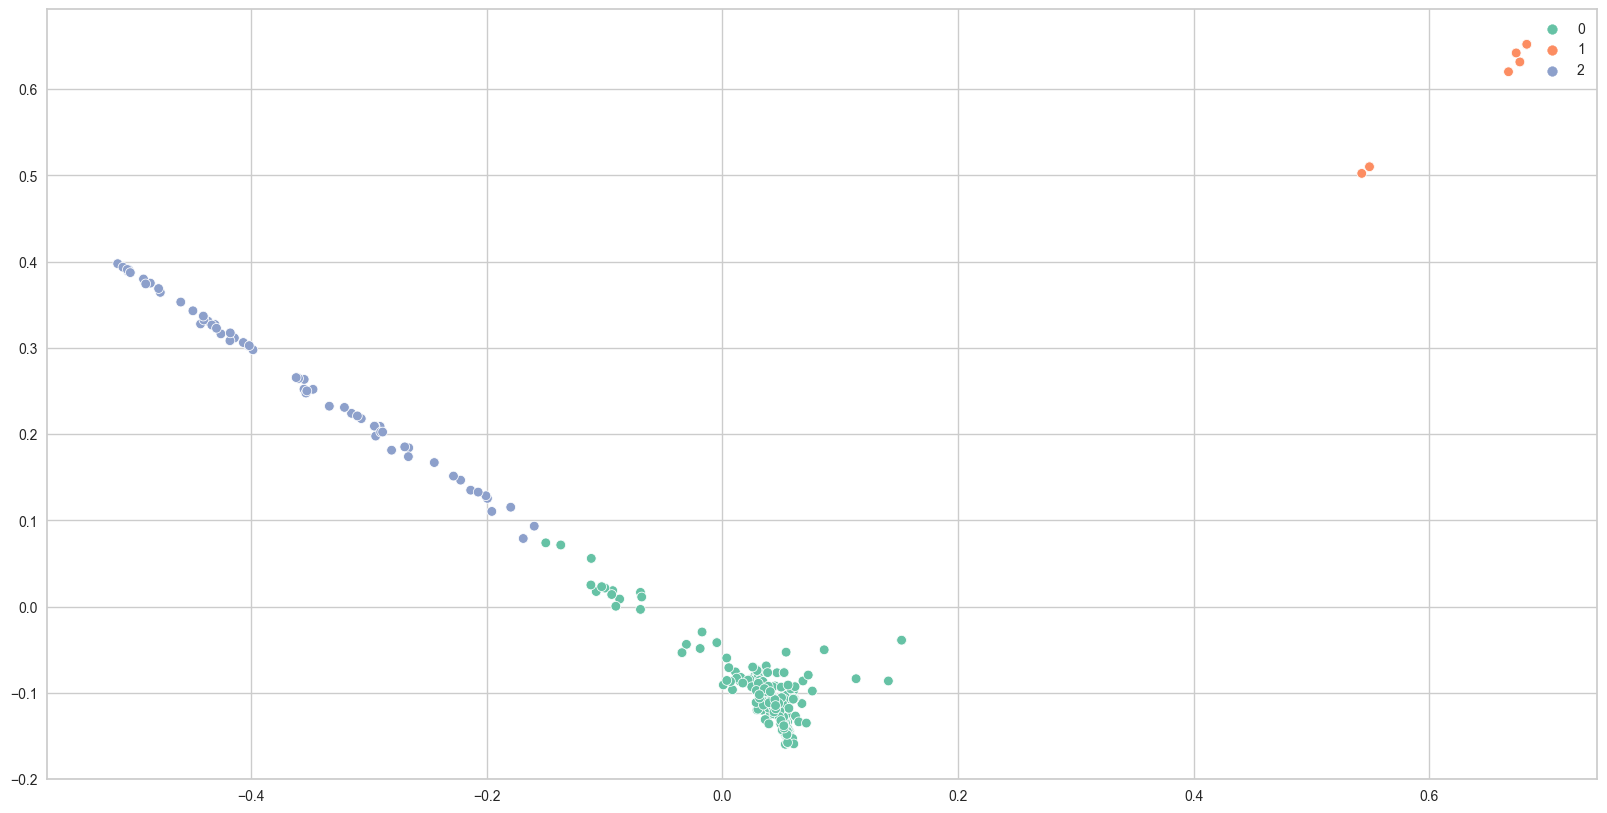

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))

# Assuming X_pca is your PCA-transformed data and pred_labels is your predicted labels
# X_pca = ...
# pred_labels = ...

# Using Seaborn's scatterplot with the 'hue' parameter to color points based on labels
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=pred_labels, palette='Set2')

# Rest of your code
colors = ['red', 'green', 'blue', 'yellow']
for i, color in enumerate(df_centers.index.tolist()):
    # Your code to plot the centers with different colors
    pass

plt.show()


#### Conclusion on clustering result

<b>Create <mark>frequent terms dataframe</mark> for each labels</b>:

In [67]:
df['label'] = pred_labels
#df = df[['OriginalTweet','label']]
df = df[['text','label']]
label1 = df[df['label']==0]
label2 = df[df['label']==1]
label3 = df[df['label']==2]
#words1 = get_word(get_all_str(label1['OriginalTweet']))
#words2 = get_word(get_all_str(label2['OriginalTweet']))
#words3 =  get_word(get_all_str(label3['OriginalTweet']))
words1 = get_word(get_all_str(label1['text']))
words2 = get_word(get_all_str(label2['text']))
words3 =  get_word(get_all_str(label3['text']))
df1 = Freq_df(words1)
df2 = Freq_df(words2)
df3 = Freq_df(words3)

# <b> Visualize<mark> top 10 frequent</mark> words with bar plot: </b>

In [72]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='grupo 1', x=df3['Term'][:10].values, y=df3['Frequency'][:10].values,text=df1['Frequency'][:10].values,marker_color='blue'),
    go.Bar(name='grupo 2', x=df2['Term'][:10].values, y=df2['Frequency'][:10].values,text=df1['Frequency'][:10].values,marker_color='yellow'),
    go.Bar(name='grupo 3', x=df1['Term'][:10].values, y=df1['Frequency'][:10].values,text=df1['Frequency'][:10].values,marker_color='red')
    ])
fig.update_layout(barmode='stack', xaxis_tickangle=-45,title='top 10 termos frequentes em cada clusters', template='simple_white')

fig.show()